In [3]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

Equation:

$$
0 = \max_{e} \min_{h_2} -\delta \phi(y, z_2) + \delta \eta \log e - \delta(1-\eta) \left(\gamma_1 y z_2 + \frac{\gamma_2}{2}y^2z_2^2 \right) + \xi_m\frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e  + \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)}
$$

In [28]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = -δ*η*y_mat

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = - δ*η / (v0_dy+(η-1)*(γ_1+γ_2*y_mat*z_mat)*z_mat)
        e[e<=0] = 1e-10
        h = - (v0_dz*np.sqrt(z_mat)*σ_2 + (η-1)*(γ_1+γ_2*y_mat*z_mat)*y_mat*np.sqrt(z_mat)*σ_2) / ξ_m

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*(γ_1+γ_2*y_mat*z_mat)*(z_mat*e+y_mat*(-ρ*(z_mat-μ_2))+y_mat*np.sqrt(z_mat)*σ_2*h+γ_2*z_mat/2*y_mat**2*σ_2**2)

        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [29]:
# Model parameters
η = .032
ξ_m = .00256
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
γ_1 = 1.7675/10000
γ_2 = 0.0022*2

pde_paras = (η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2 - 6*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 6*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 100
y_min = 1e-2
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [30]:
ϕ_grid, e_grid = false_transient(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.7029408102936274; RHS Error 0.2396853514200269
Iteration 2: LHS Error: 0.8176348505187194; RHS Error 1.110917214482252
Iteration 3: LHS Error: 0.5117287000019077; RHS Error 2.255252035553994
Iteration 4: LHS Error: 1.0817279937049742; RHS Error 0.8590638566363086
Iteration 5: LHS Error: 12.511272225047719; RHS Error 2.8145439340715095
Iteration 6: LHS Error: 5.743337171405198; RHS Error 172.75999976171525
Iteration 7: LHS Error: 3.656950453189485; RHS Error 40.3717812285491
Iteration 8: LHS Error: 2.06088898532132; RHS Error 9.490281779609766
Iteration 9: LHS Error: 11.702213076187752; RHS Error 143.10914548649868
Iteration 10: LHS Error: 5.33712693270279; RHS Error 24449.298092756755
Iteration 11: LHS Error: 6.568217974491274; RHS Error 32501.707951777098
Iteration 12: LHS Error: 6.2042394446440765; RHS Error 18799.003775929894
Iteration 13: LHS Error: 3.1881728130010822; RHS Error 4465.116424278085
Iteration 14: LHS Error: 1.6071391799025108; RHS Error 771.9

Iteration 117: LHS Error: 0.007207158399413771; RHS Error 0.007363341700535205
Iteration 118: LHS Error: 0.008905192914267612; RHS Error 0.008055951252306195
Iteration 119: LHS Error: 0.007484493111083346; RHS Error 0.007544328046854242
Iteration 120: LHS Error: 0.007171314225500991; RHS Error 0.00732874771785251
Iteration 121: LHS Error: 0.008850445362559745; RHS Error 0.008019105272813173
Iteration 122: LHS Error: 0.007446224378511612; RHS Error 0.007508974677545091
Iteration 123: LHS Error: 0.007137428368121368; RHS Error 0.007293707887136812
Iteration 124: LHS Error: 0.007802085440006601; RHS Error 0.007635238059307936
Iteration 125: LHS Error: 0.007270722944528574; RHS Error 0.007363137379621073
Iteration 126: LHS Error: 0.008215755623175003; RHS Error 0.008177502004265147
Iteration 127: LHS Error: 0.0072379544325861245; RHS Error 0.007502672193810959
Iteration 128: LHS Error: 0.007195769295521348; RHS Error 0.0072707014362428275
Iteration 129: LHS Error: 0.00798688694845906; RHS 

Iteration 227: LHS Error: 0.0053805571483800385; RHS Error 0.00733189170018729
Iteration 228: LHS Error: 0.0057015893731733325; RHS Error 0.0087613925060612
Iteration 229: LHS Error: 0.005308610349434972; RHS Error 0.005798727336604456
Iteration 230: LHS Error: 0.009291310559556343; RHS Error 0.00648218454955991
Iteration 231: LHS Error: 0.006018572656199761; RHS Error 0.0056486458951188825
Iteration 232: LHS Error: 0.015908113198295215; RHS Error 0.0057206194219904735
Iteration 233: LHS Error: 0.007911548321861084; RHS Error 0.006062746204337756
Iteration 234: LHS Error: 0.006437612951315175; RHS Error 0.0056876358539902985
Iteration 235: LHS Error: 0.016288257933091466; RHS Error 0.012696944891037676
Iteration 236: LHS Error: 0.0123020427543451; RHS Error 0.0618231049776683
Iteration 237: LHS Error: 0.16197209036873694; RHS Error 0.18788916537413142
Iteration 238: LHS Error: 0.8857754847427883; RHS Error 1.8218405957884245
Iteration 239: LHS Error: 0.26120691896663717; RHS Error 59.7

Iteration 337: LHS Error: 0.007334856748588914; RHS Error 0.007235654051238015
Iteration 338: LHS Error: 0.005379825230246382; RHS Error 0.005463217884062191
Iteration 339: LHS Error: 0.004973636886017263; RHS Error 0.00507791242462205
Iteration 340: LHS Error: 0.007381624358713923; RHS Error 0.005687079564642802
Iteration 341: LHS Error: 0.0065822804254878076; RHS Error 0.005550599871503525
Iteration 342: LHS Error: 0.005305704982571435; RHS Error 0.005181929092755173
Iteration 343: LHS Error: 0.0056232417203432306; RHS Error 0.005278571420468892
Iteration 344: LHS Error: 0.004827588664759186; RHS Error 0.004921024285330176
Iteration 345: LHS Error: 0.004711768282100737; RHS Error 0.005003633903143265
Iteration 346: LHS Error: 0.00468393277923429; RHS Error 0.004699066404154708
Iteration 347: LHS Error: 0.004654931907004611; RHS Error 0.004674268130490041
Iteration 348: LHS Error: 0.009970482998958863; RHS Error 0.005592030022223735
Iteration 349: LHS Error: 0.00635276223133574; RHS E

Iteration 448: LHS Error: 2377521018.616985; RHS Error 8.93937265208774e+21
Iteration 449: LHS Error: 1908766697.9279118; RHS Error 4.876694055367142e+21
Iteration 450: LHS Error: 960193724.8562487; RHS Error 1.4636468402667672e+21
Iteration 451: LHS Error: 1226671896.7217839; RHS Error 8.089796673903488e+20
Iteration 452: LHS Error: 910027539.5619023; RHS Error 5.2687356083915175e+20
Iteration 453: LHS Error: 697271364.2098001; RHS Error 5.029514353113477e+20
Iteration 454: LHS Error: 536904354.4024514; RHS Error 2.821441268186403e+20
Iteration 455: LHS Error: 416282536.07358307; RHS Error 1.6188862801326493e+20
Iteration 456: LHS Error: 323555693.8440435; RHS Error 9.397500118393782e+19
Iteration 457: LHS Error: 251818984.0555759; RHS Error 5.4880723022272455e+19
Iteration 458: LHS Error: 196386000.03341398; RHS Error 3.2239178144137675e+19
Iteration 459: LHS Error: 153021187.83153442; RHS Error 1.877649373056081e+19
Iteration 460: LHS Error: 119236812.53952527; RHS Error 1.096202641

Iteration 557: LHS Error: 43751968.173379734; RHS Error 1.7356392154648074e+18
Iteration 558: LHS Error: 33910635.00296026; RHS Error 1.5066063098394214e+18
Iteration 559: LHS Error: 25507902.422775008; RHS Error 4.554825140945771e+17
Iteration 560: LHS Error: 19199678.14473751; RHS Error 4.319670510427053e+17
Iteration 561: LHS Error: 14401464.427774897; RHS Error 2.2876386415171334e+17
Iteration 562: LHS Error: 10962291.525147071; RHS Error 1.27520888274214e+17


KeyboardInterrupt: 

In [ ]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [ ]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)

In [ ]:
plt.plot(Et)

In [121]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [122]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

Text(0.5, 0, 'Year')

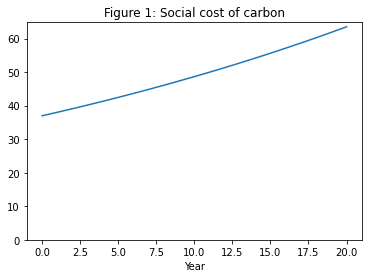

In [123]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [61]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

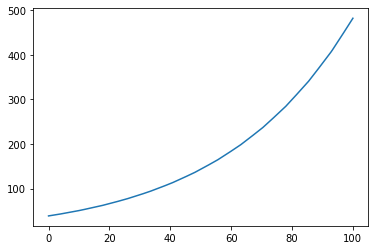

In [40]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [45]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [102]:
(1-δ/(α-ioverk))/ioverk

6.666666666666668

In [114]:
-0.0429 + ioverk - κ/2.*ioverk**2

0.02009865

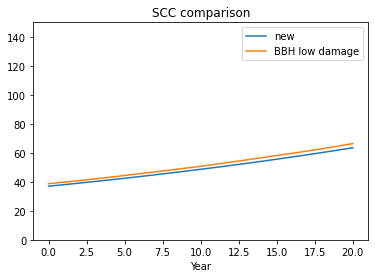

In [124]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

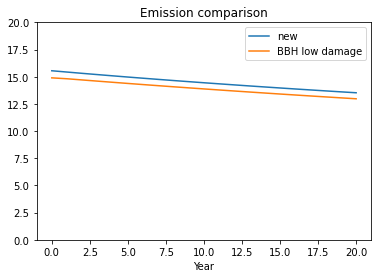

In [71]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [66]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])